In [6750]:
import sys
import importlib
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import grad


In [6751]:
sys.path.append('..')  # Go up one directory to where utils.py is located
import utils  # Ensure you import the module itself, not specific items
importlib.reload(utils)  # Reload the module to apply updates
from utils import *

Consider the simple harmonic oscillator $x:\mathbb{R}^+ \to \mathbb{R}$ given by:
$$ \begin{cases}
\frac{d^2x}{dt^2} &= -\omega^2 x \\
x(0) &= q_0 \\
\frac{dx}{dt}|_{t=0}& = p_0.
\end{cases},
$$
which can be reformulated as a system of differential equations
$$ 
\begin{cases}
\frac{dx}{dt} = y \\
\frac{dy}{dt} = -\omega^2 x  \\
x(0) = q_0 \\
y(0) = p_0,
\end{cases}
$$
where we defined $y:= \frac{dx}{dt}$. Our goal is to implement a simple DeepONet to approximate a solution for this BVP.

The analytical solution of the BVP is 
$$
\begin{cases}
x(t) = q_0 \cos(\omega t) + \frac{p_0}{\omega}\sin(\omega t)\\
y(t) = p_0 \cos(\omega t) - q_0 \omega \sin(\omega t).
\end{cases}
$$

In [6752]:
# Get analytical solution of the BVP for given q0, p0 and t
def analytic_solution(bv, t, w=1):
    q0 = bv[:,None,0] 
    p0 = bv[:,None,1] 
    x = torch.tensor(q0 @ np.cos(w * t).T + (p0 @ np.sin(w * t).T) / w)
    y = torch.tensor(p0 @ np.cos(w * t).T - (q0 @ np.sin(w * t).T) * w)
    return torch.stack((x, y), dim=2)

In [6753]:
def PI_loss_fn(u, t, w=1):

    x, y = u[...,0], u[...,1]
    
    ones = torch.ones_like(u[0,:,0])
    
    x_t = torch.stack([grad(xi.T, t, grad_outputs=ones, create_graph=True)[0].squeeze(-1) for xi in x])
    y_t = torch.stack([grad(yi.T, t, grad_outputs=ones, create_graph=True)[0].squeeze(-1) for yi in y])

    return torch.stack((x_t - y, y_t + (w**2)*x))    

In [6754]:
T = 5
bv_ = np.random.uniform(low=-1, high=1, size=(3, 2)).astype(np.float32)
t = np.random.uniform(low=0, high=T, size=(10, 1)).astype(np.float32)
Px = (bv_, t)

In [6755]:
bv = np.random.uniform(low=-1, high=1, size=(10, 2)).astype(np.float32)
t = np.random.uniform(low=0, high=T, size=(10, 1)).astype(np.float32)
y_train = analytic_solution(bv, t)
X_train = (bv, t)


In [6756]:
bv = np.random.uniform(low=-1, high=1, size=(10, 2)).astype(np.float32)
t = np.random.uniform(low=0, high=T, size=(10, 1)).astype(np.float32)
y_test = analytic_solution(bv, t)
X_test = (bv, t)


In [6757]:
num_pts = 10
grid_points = torch.linspace(-1, 1, num_pts, requires_grad=False, dtype=torch.float32)
mesh = torch.cartesian_prod(grid_points, grid_points)

t = torch.zeros((1, 1))
X_col = (mesh, t)

In [6758]:
net = DeepONet([40, 40, 40], [40, 40, 40], dim=2, K=2, activation='tanh', conserve_energy=False, symplectic=True)
model = Model(X_train, y_train, X_test, y_test, X_col, net, Px=None, PI_loss_fn=None, Tmax=5)
model.train(iterations=30_001)

Step 	 Train loss 	 Test loss
1000 	 [3.11e-03] 	 [3.09e-03]
2000 	 [1.54e-03] 	 [1.66e-03]
3000 	 [2.26e-03] 	 [2.93e-03]
4000 	 [1.42e-03] 	 [2.35e-03]
5000 	 [5.75e-05] 	 [8.17e-05]
6000 	 [9.83e-05] 	 [1.69e-04]
7000 	 [2.05e-05] 	 [2.84e-05]
8000 	 [2.38e-05] 	 [5.76e-05]
9000 	 [3.54e-05] 	 [7.81e-05]
10000 	 [5.89e-06] 	 [4.02e-05]
11000 	 [1.08e-04] 	 [1.37e-04]
12000 	 [6.08e-06] 	 [4.79e-05]
13000 	 [5.31e-06] 	 [4.50e-05]
14000 	 [2.54e-05] 	 [6.17e-05]
15000 	 [8.08e-04] 	 [9.17e-04]
16000 	 [5.31e-06] 	 [5.03e-05]
17000 	 [6.36e-06] 	 [4.89e-05]
18000 	 [4.43e-06] 	 [5.00e-05]


KeyboardInterrupt: 

In [6759]:
def test_symplecticity(T, num_pts=100):

        J = torch.tensor([[0, 1], [-1, 0]], dtype=torch.float32)[None,...]
        #norm_J = torch.linalg.norm(J)
        
        grid_points = torch.linspace(-1, 1, num_pts, requires_grad=True, dtype=torch.float32)
        mesh = torch.cartesian_prod(grid_points, grid_points)
        #print(mesh)
        
        t = torch.tensor([T], requires_grad=True, dtype=torch.float32).reshape(-1, 1)
        
        delta_J = []
        
        N = model.net(mesh, t)
        
        print(torch.max(torch.abs(N[:,0,:] - mesh)))
            
        row1 = grad(N[...,0], mesh, grad_outputs=torch.ones_like(N[...,0]), retain_graph=True)[0]
        
        row2 = grad(N[...,1], mesh, grad_outputs=torch.ones_like(N[...,1]), retain_graph=True)[0]
        
        
        det = row1[:,0]*row2[:,1] - row1[:,1]*row2[:,0]            
            
                
        det = np.array(det).reshape(num_pts, num_pts)
        plt.figure(figsize=(8, 6))
        plt.imshow(det, extent=(-1, 1, -1, 1), origin='lower', cmap='viridis')
        plt.colorbar(label='$\Delta J$')
        plt.title("$\Delta J = || \\nabla \mathcal{N}(t)^T J \\nabla \mathcal{N}(t) - J||/||J||$ over $(q,p)$-grid, for t=" + f"{T}")
        plt.xlabel('q')
        plt.ylabel('p')
        plt.show()

tensor(0.0016, grad_fn=<MaxBackward1>)


/var/folders/43/0xc7h8213cs2gpcym99hxdqm0000gn/T/ipykernel_63187/424319626.py:26: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  det = np.array(det).reshape(num_pts, num_pts)


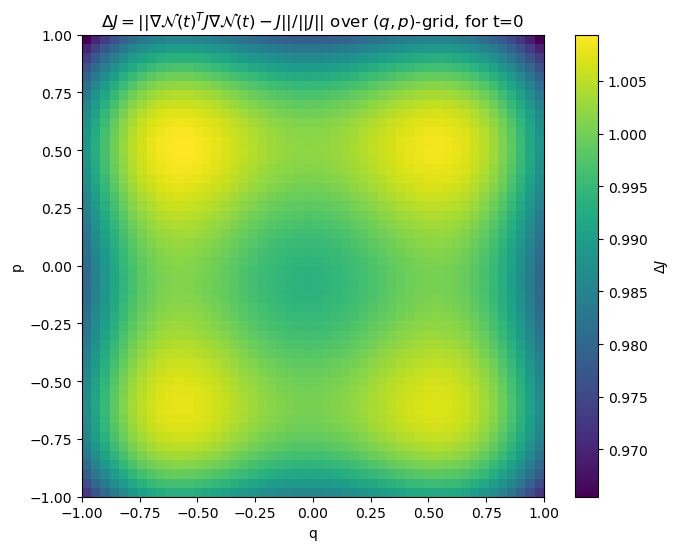

In [6760]:
#test_symplecticity(T=2, num_pts=50)
#test_symplecticity(T=0.5, num_pts=50)
test_symplecticity(T=0, num_pts=50)

In [6761]:
def plot_energy(q0, p0, dpi=100):
        
    # Energy test boundary values
    energy_bv =  torch.tensor([[q0, p0]], dtype=torch.float32).requires_grad_(True)
    
    # Energy test time-domain
    energy_t = torch.linspace(0, 5, 100, requires_grad=True).reshape(-1, 1).requires_grad_(True)
    
    # Calculate total energy
    u = model.net(energy_bv, energy_t)   
    x, y = u[..., 0], u[..., 1]        
    E = (x**2 + y**2)/2
            
    _, ax = plt.subplots(figsize=(8, 2), dpi=dpi)
    t = energy_t.detach()
    
    ax.set_title(f'Total Energy of DeepONet Prediction $(q_0, p_0)$=({q0}, {p0})')
    ax.plot(t, torch.ones_like(t)*(q0**2 + p0**2)/2, alpha=0.5, linewidth=5, label='True energy')
    ax.plot(t, E[0,...].detach(), '--', alpha=0.8, linewidth=3,  label='DeepONet energy')
    ax.legend()
    ax.grid(True)
    
    ax.set_xlabel("t")
    ax.set_ylabel("Total energy")
    plt.show()

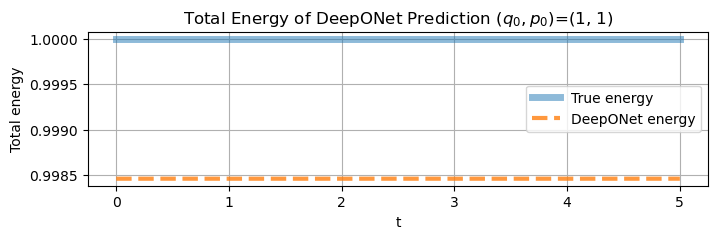

In [6762]:
plot_energy(q0=1, p0=1)

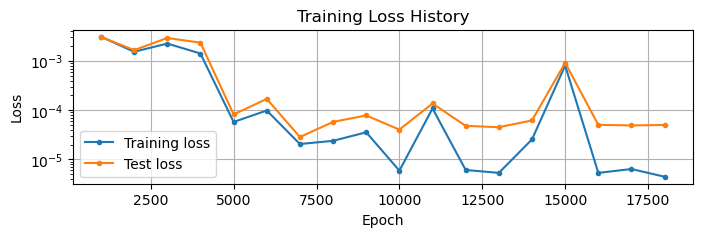

In [6763]:
model.plot_losshistory()

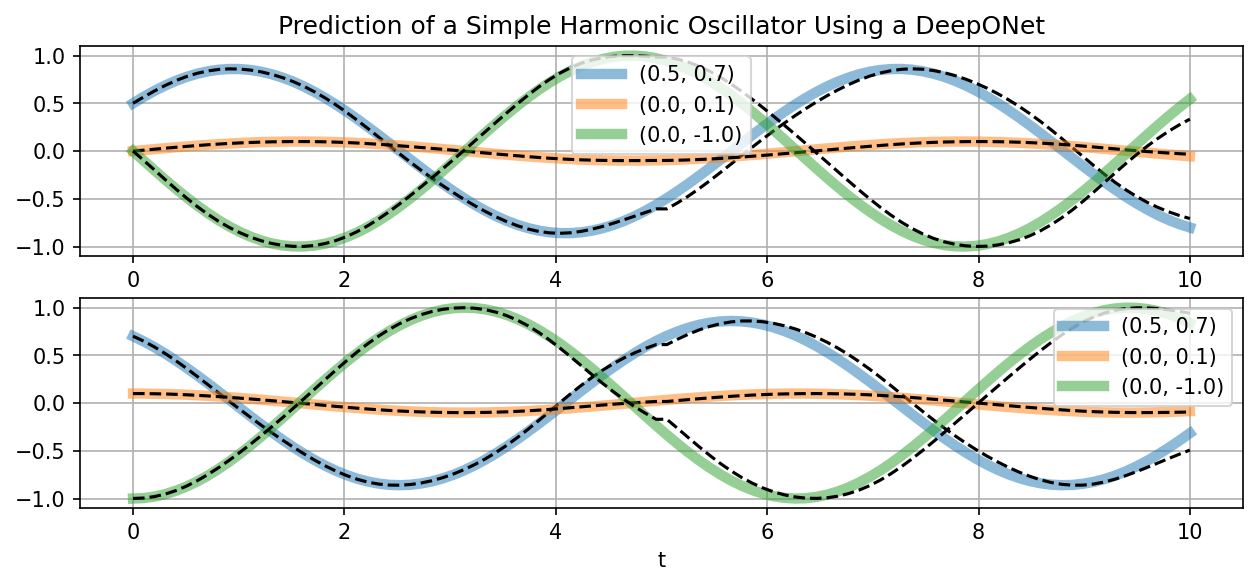

In [6764]:
# Plot model prediction for one omega

# Get model prediction

t_0_5 = np.linspace(0, 5, 50).reshape(-1, 1)
t5 = np.array([5]).reshape(-1, 1)

t = np.linspace(0, 10, 100).reshape(-1, 1)

bv = np.array([[0.5, 0.7], [0, 0.1], [0,-1]]).astype(np.float32)

ground_truth = analytic_solution(bv, t)


pred_0_5 = model.predict(bv, t_0_5)
pred_5_10 = model.predict(model.predict(bv, t5)[:,0,:], t_0_5)

pred = torch.concatenate((pred_0_5, pred_5_10), axis=1)



# Plot prediction vs. solution
fig, axes = plt.subplots(2, 1, figsize=(10, 4), dpi=150)

axes[0].set_title('Prediction of a Simple Harmonic Oscillator Using a DeepONet')

for k, ax in enumerate(axes.flat):
    for l in range(pred.shape[0]):
        label = '({:.1f}, {:.1f})'.format(bv[l,0], bv[l,1])
        ax.plot(t.flatten(), ground_truth[l,:,k], label=label, alpha=0.5, linewidth=5)
        ax.plot(t.flatten(), pred[l,:,k].tolist(), '--', c='k')

    ax.legend()
    ax.grid(True)
ax.set_xlabel("t")
plt.show()

In [6769]:
# # Plot model prediction for one omega

# # Get model prediction

# t = np.zeros((1,1))

# num_pts = 10
# grid_points = torch.linspace(-1, 1, num_pts, requires_grad=False, dtype=torch.float32)
# mesh = torch.cartesian_prod(grid_points, grid_points)

# ground_truth = analytic_solution(mesh, t)

# pred = model.predict(mesh, t)




# q_pred = pred[:,0,0].reshape(num_pts, num_pts).detach()
# p_pred = pred[:,0,1].reshape(num_pts, num_pts).detach()




# q = ground_truth[:,0,0].reshape(num_pts, num_pts).detach()
# p = ground_truth[:,0,1].reshape(num_pts, num_pts).detach()


# plt.figure(figsize=(8, 6))
# plt.imshow(torch.abs(q_pred-q), extent=(-1, 1, -1, 1), origin='lower', cmap='viridis')
# plt.colorbar(label='label')
# plt.title("Title")
# plt.xlabel('q')
# plt.ylabel('p')
# plt.show()

# plt.figure(figsize=(8, 6))
# plt.imshow(torch.abs(p_pred-p), extent=(-1, 1, -1, 1), origin='lower', cmap='viridis')
# plt.colorbar(label='label')
# plt.title("Title")
# plt.xlabel('q')
# plt.ylabel('p')
# plt.show()

In [6766]:
class M():
    
    def __init__(
        self, x_train, y_train, x_test, y_test, net, optimizer='adam', lr=0.001):     
        
        # Training data
        self.x_train = x_train
        self.y_train = y_train
        
        # Testing data
        self.x_test = x_test
        self.y_test = y_test

        
        # Network
        self.net = net
        
        # Loss history
        self.tlosshistory = []  # training loss
        self.vlosshistory = []  # validation/test loss

        # Initialize optimizer (default adam)
        optimizer = {'adam':torch.optim.Adam, 'sgd':torch.optim.SGD}[optimizer]
        self.optimizer = optimizer(net.parameters(), lr=lr)
        
        # Set loss function (MSE default)
        self.mse = torch.nn.MSELoss()
        
        self.loss_fn = self.MSE_loss 
                
        
    # Format data as torch tensor with dtype=float32    
    def format(self, x, requires_grad=False):
        x = x if isinstance(x, torch.Tensor) else torch.tensor(x)
        return x.to(torch.float32).requires_grad_(requires_grad)
    
    def MSE_loss(self, prediction, targets):
        return self.mse(prediction, targets)
        
        
    # Train network
    def train(self, iterations):
        
        # Train step history
        self.steps = []
        
        # Set net to train mode
        self.net.train(True)
        
        # Training process updates
        print('Step \t Train loss \t Test loss')

        for iter in range(iterations):
            
            
            # Train
            self.optimizer.zero_grad()
            prediction = self.net(self.x_train)
            
            
            loss = self.loss_fn(prediction, self.y_train)
            
            
            loss.backward(retain_graph=True)
            self.optimizer.step()
            tloss = loss.item()

            # Test
            if iter % 1000 == 999:
                # Set net to evalutation mode
                self.net.eval()
                
                # Don't calculate gradients
                with torch.no_grad():
                
                    outputs = self.net(self.x_test)  
                    vloss = self.loss_fn(outputs, self.y_test).item()
                    
    
                # Save loss history
                self.vlosshistory.append(vloss)
                self.tlosshistory.append(tloss)
                self.steps.append(iter)
                self.net.train(True)
                
                print('{} \t [{:.2e}] \t [{:.2e}]'.format(iter + 1, tloss, vloss))    
                
                
                        
            
            
    def plot_losshistory(self, dpi=100):
        # Plot the loss trajectory
        _, ax = plt.subplots(figsize=(8, 2), dpi=dpi)
        ax.plot(self.steps, self.tlosshistory, '.-', label='Training loss')
        ax.plot(self.steps, self.vlosshistory, '.-', label='Test loss')
        ax.set_title("Training Loss History")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.set_yscale('log')
        ax.grid(True)
        ax.legend()
        plt.show()
        
                
        

In [ ]:
bv = -2 * torch.rand(50, 2, dtype=torch.float32) + 1
t = torch.linspace(0, T, 100, dtype=torch.float32)[:,None]

x_train = model.predict(bv, t)
#x_train = bv
y_train = torch.linalg.norm(x_train, dim=-1, keepdim=True)

bv = -2 * torch.rand(10, 2, dtype=torch.float32) + 1
t = torch.linspace(0, T, 100, dtype=torch.float32)[:,None]

x_test = model.predict(bv, t)
y_test = torch.linalg.norm(x_test, dim=-1, keepdim=True)





H = FNN([2, 40, 40, 40, 1])

m = M(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test, net=H)
m.train(10_000)


Step 	 Train loss 	 Test loss
1000 	 [3.76e-03] 	 [1.45e-03]


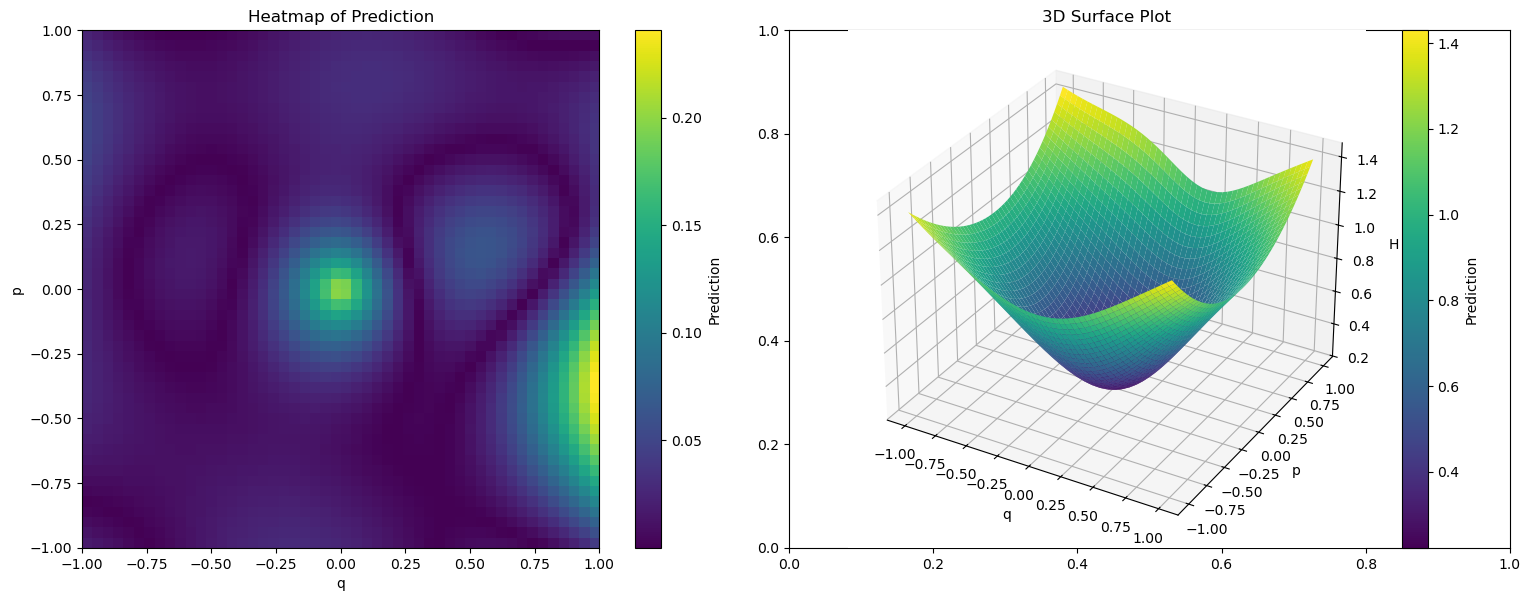

In [ ]:
# Plot model prediction for one omega

# Get model prediction

t = np.zeros((1,1))

num_pts = 50
grid_points = torch.linspace(-1, 1, num_pts, requires_grad=False, dtype=torch.float32)
mesh = torch.cartesian_prod(grid_points, grid_points)

H_true = torch.linalg.norm(mesh, dim=-1, keepdim=True).reshape(num_pts, num_pts).detach()

pred = H(mesh).reshape(num_pts, num_pts).detach()






fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# First subplot: Heatmap
heatmap = axes[0].imshow(np.abs(pred.numpy() - H_true.numpy()), extent=(-1, 1, -1, 1), origin='lower', cmap='viridis')
axes[0].set_title("Heatmap of Prediction")
axes[0].set_xlabel('q')
axes[0].set_ylabel('p')

# Add colorbar for the heatmap
plt.colorbar(heatmap, ax=axes[0], label='Prediction')

# Second subplot: Surface plot
ax = fig.add_subplot(122, projection='3d')

# Create the 2D grid
X, Y = torch.meshgrid(grid_points, grid_points)
X = X.numpy()  # Convert torch tensor to numpy for plotting
Y = Y.numpy()  # Convert torch tensor to numpy for plotting
Z = pred.numpy()  # Predicted values (also as numpy)

# Plot the surface
surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')

# Add color bar and labels
fig.colorbar(surf, ax=ax, label='Prediction')
ax.set_title("3D Surface Plot")
ax.set_xlabel('q')
ax.set_ylabel('p')
ax.set_zlabel('H')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()